## Random Forest Model

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSC-680 Capstone/output/sample_data_modeling.csv')

In [4]:
df['click_time'] = pd.to_datetime(df['click_time'])
df['click_date'] = pd.to_datetime(df['click_date'])

In [5]:
df['is_attributed'].value_counts()

0    46184
1     9065
Name: is_attributed, dtype: int64

### Create Training and Test sets

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
X = df[['median_time_diff_app', 'median_time_diff_channel',
        'hour_0_to_8', 'hour_8_to_16',
        'hour_16_to_24', 'app_encoded',
        'channel_encoded', 'os_encoded', 'device_encoded', 'ctr']]

In [8]:
feature_names = X.columns
feature_names

Index(['median_time_diff_app', 'median_time_diff_channel', 'hour_0_to_8',
       'hour_8_to_16', 'hour_16_to_24', 'app_encoded', 'channel_encoded',
       'os_encoded', 'device_encoded', 'ctr'],
      dtype='object')

In [9]:
y = df['is_attributed']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (41436, 10)
X_test shape: (13813, 10)


### Feature Selection

In [12]:
# create Pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier


In [13]:
sfs = SequentialFeatureSelector(estimator=RandomForestClassifier(), n_features_to_select=5)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=RandomForestClassifier(),
                          n_features_to_select=5)

In [14]:
feature_names_new = feature_names[sfs.get_support()]
feature_names_new

Index(['hour_16_to_24', 'channel_encoded', 'os_encoded', 'device_encoded',
       'ctr'],
      dtype='object')

> Feature selection took 3 minutes and 31 seconds

In [15]:
X_new = X[feature_names_new]

In [16]:
print(f'X_new.shape: {X_new.shape}')

X_new.shape: (55249, 5)


### GridSearch Cross Validation (GridSearchCV)
Use a grid search cross-validation on new features for selection of the optimal parameters. Exhaustive search for optimal set of parameters that produce the best score for the model.  Several iterations of cross validation for every combination of parameter values.

GridSearchCV tries all possible combinations of the specified parameters. Therefore, adding more parameters to your grid exponentially increases the number of models that need to be built.

In [17]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, random_state=1)

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {'max_depth': [2, 3, 4, 5] }

In [20]:
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
grid.fit(X_train_new, y_train_new)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test_new, y_test_new)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 1.00
Test set score: 1.00
Best parameters: {'max_depth': 4}


In [21]:
grid.best_params_['max_depth']

4

In [22]:
max_depth = grid.best_params_['max_depth']
max_depth

4

### Cross Validation

In [23]:
print(f'X_train_new shape: {X_train_new.shape}')
print(f'X_test_new shape: {X_test_new.shape}')

X_train_new shape: (41436, 5)
X_test_new shape: (13813, 5)


In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [25]:
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(RandomForestClassifier(max_depth=max_depth), X_train_new, y_train_new, cv=s_kfold)
scores

array([0.99674228, 0.9971039 , 0.99589719, 0.99782792, 0.99686256])

In [26]:
scores.mean()

0.9968867686188491

### Evaluate on Test data set

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [28]:
def eval_rf_tree():
  '''
  Fit Decision Tree to training set and evaulate against test set.

  returns:
    y_true: true values
    y_pred: predictions
  '''
  clf = RandomForestClassifier(max_depth=max_depth)
  clf.fit(X_train_new, y_train_new)

  y_true = y_test_new
  y_pred = clf.predict(X_test_new)

  return y_true, y_pred, clf

In [29]:
def display_confusion_matrix(cm, title, clf):
  '''
  Plot confusion matrix

  params:
    cm: confusion matrix
  '''
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

  fig, ax = plt.subplots(figsize=(5,4))
  ax.set_title(title)
  disp.plot(ax=ax, cmap='Blues')
  plt.show()

In [30]:
def print_classification_report(cm):
  '''
  Print classification report

  params:
    cm: confusion matrix
  '''
  tn, fp, fn, tp = cm.ravel()
  accuracy = (tp + tn) / (tp + fp + tn + fn)
  print(f"Accuracy: {accuracy}")

  print(f'True negatives: {tn}')
  print(f'False positives: {fp}')
  print(f'False negatives: {fn}')
  print(f'True positives: {tp}')

  print(classification_report(y_true, y_pred))

In [31]:
# Retrain model on entire training set
y_true, y_pred, clf = eval_rf_tree()

In [32]:
clf.score(X_test_new, y_test_new)

0.9975385506407007

In [33]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[11539,     9],
       [   25,  2240]])

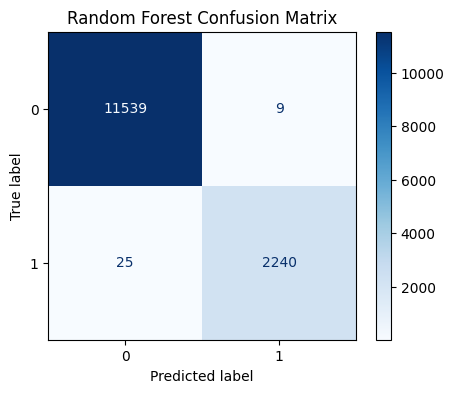

In [34]:
display_confusion_matrix(cm, 'Random Forest Confusion Matrix', clf)

In [35]:
print_classification_report(cm)

Accuracy: 0.9975385506407007
True negatives: 11539
False positives: 9
False negatives: 25
True positives: 2240
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11548
           1       1.00      0.99      0.99      2265

    accuracy                           1.00     13813
   macro avg       1.00      0.99      1.00     13813
weighted avg       1.00      1.00      1.00     13813



In [36]:
sorted(zip(clf.feature_importances_, X_new.columns), reverse=True)

[(0.6051578995931645, 'ctr'),
 (0.29723092284733416, 'channel_encoded'),
 (0.0695981923420668, 'os_encoded'),
 (0.02781522181574562, 'device_encoded'),
 (0.00019776340168895334, 'hour_16_to_24')]

### Evaluate with Cluster categorical variables

In [37]:
X = df[['median_time_diff_app', 'median_time_diff_channel',
        'hour_0_to_8', 'hour_8_to_16',
        'hour_16_to_24', 'app_encoded',
        'channel_encoded', 'os_encoded', 'device_encoded', 'ctr',
        'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']]

In [38]:
new_feature_cols = feature_names_new.tolist()
new_feature_cols.extend(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'])
new_feature_cols

['hour_16_to_24',
 'channel_encoded',
 'os_encoded',
 'device_encoded',
 'ctr',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3']

#### Retrain on new cluster columns

In [39]:
X.columns

Index(['median_time_diff_app', 'median_time_diff_channel', 'hour_0_to_8',
       'hour_8_to_16', 'hour_16_to_24', 'app_encoded', 'channel_encoded',
       'os_encoded', 'device_encoded', 'ctr', 'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3'],
      dtype='object')

In [40]:
X_new = X[new_feature_cols]
X_new.columns

Index(['hour_16_to_24', 'channel_encoded', 'os_encoded', 'device_encoded',
       'ctr', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'],
      dtype='object')

In [41]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, random_state=1)

In [42]:
X_train_new.shape

(41436, 9)

In [43]:
y_train_new.shape

(41436,)

In [44]:
# Retrain model on entire training set
y_true, y_pred, clf = eval_rf_tree()

In [45]:
clf.score(X_test_new, y_test_new)

0.9972489683631361

In [46]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[11542,     6],
       [   32,  2233]])

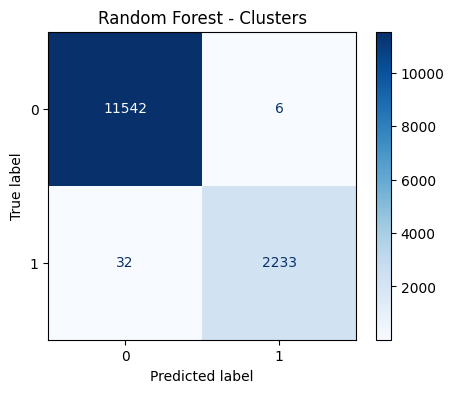

In [49]:
display_confusion_matrix(cm, 'Random Forest - Clusters', clf)

In [48]:
print_classification_report(cm)

Accuracy: 0.9972489683631361
True negatives: 11542
False positives: 6
False negatives: 32
True positives: 2233
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11548
           1       1.00      0.99      0.99      2265

    accuracy                           1.00     13813
   macro avg       1.00      0.99      0.99     13813
weighted avg       1.00      1.00      1.00     13813

